In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile
import math

from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from numba import vectorize

print(tf.__version__)

2.4.0


In [2]:
import pathlib
dataset_url = "http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='mias',
                                   extract=True)


In [3]:
path = "/tmp/images/mias"

try:
    os.makedirs(path)
except Exception as e:
    print(e)

data_dir = pathlib.Path(os.path.dirname(data_dir))

#save images in png
for file in data_dir.glob('*.pgm'):
    file_name = file.name
    new_name = path + '/' + file.stem + ".png"
    Image.open(file).save(new_name)

data_dir = pathlib.Path(os.path.dirname(path))
print(data_dir)

/tmp/images


In [4]:
img_height = 512
img_width = 512

batch_size = 1

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory= data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale",
  label_mode=None)


Found 322 files belonging to 1 classes.
Using 258 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale",
  label_mode=None)


Found 322 files belonging to 1 classes.
Using 64 files for validation.


In [7]:
print(val_ds.cardinality().numpy())
print(train_ds.cardinality().numpy())

64
258


In [8]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [9]:
normalized_train_ds = train_ds.map(lambda x: normalization_layer(x))
del train_ds

In [10]:
normalized_val_ds = val_ds.map(lambda x: normalization_layer(x))
del val_ds

In [11]:
saved_ds = list(tfds.as_numpy(normalized_train_ds))
np.save("/home/notchla/Documents/mias_y_train2", np.squeeze(saved_ds, axis=1))
saved_ds = list(tfds.as_numpy(normalized_val_ds))
np.save("/home/notchla/Documents/mias_y_val2", np.squeeze(saved_ds, axis=1))
del saved_ds


In [15]:
@vectorize('float64(float64)', nopython=True)
def knuth(pixvalue):
    L = math.exp(- pixvalue)
    k = 0
    p = 1
    while (p>L):
        k = k + 1
        p *= np.random.uniform(0, 1)
    return k - 1

In [16]:
y_train = np.load("/home/notchla/Documents/mias_y_train2.npy", allow_pickle=True)
y_val = np.load("/home/notchla/Documents/mias_y_val2.npy", allow_pickle=True)
scaled_y_val = y_val * 255
scaled_y_train = y_train * 255

x_val = knuth(scaled_y_val)
max_val = [np.max(x) for x in x_val]
max_val = np.array(max_val)
x_val = x_val / max_val[:, np.newaxis, np.newaxis, np.newaxis]
print(np.min(x_val), np.max(x_val))
x_train = knuth(scaled_y_train)
max_train = [np.max(x) for x in x_train]
max_train = np.array(max_train)
x_train = x_train / max_train[:, np.newaxis, np.newaxis, np.newaxis]
print(np.min(x_train), np.max(x_train))

x_train = np.clip(x_train, 0, 1)
x_val = np.clip(x_val, 0, 1)

np.save("/home/notchla/Documents/mias_x_train2", x_train)
np.save("/home/notchla/Documents/mias_x_val2", x_val)

del scaled_y_train
del scaled_y_val
#test = np.apply_along_axis(vfunc_knuth, 0, scaled_y)
    

(258, 512, 512, 1)
(64, 512, 512, 1)
-0.0040650406504065045 1.0
-0.004366812227074236 1.0


In [20]:
print(np.min(y_train), np.max(y_train))
print(np.min(y_val), np.max(y_val))

0.0 1.0
0.0 0.9568628


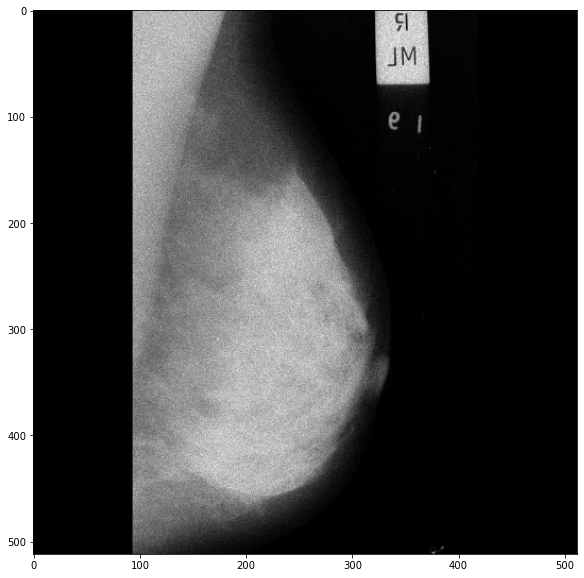

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(x_val[0])
plt.gray()

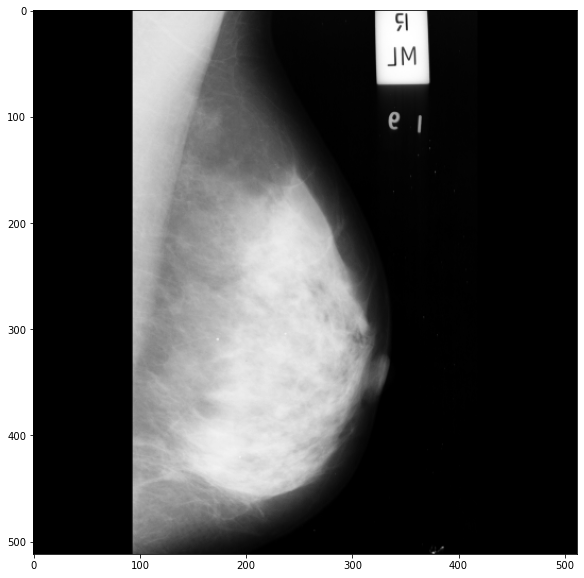

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(y_val[0])
plt.gray()

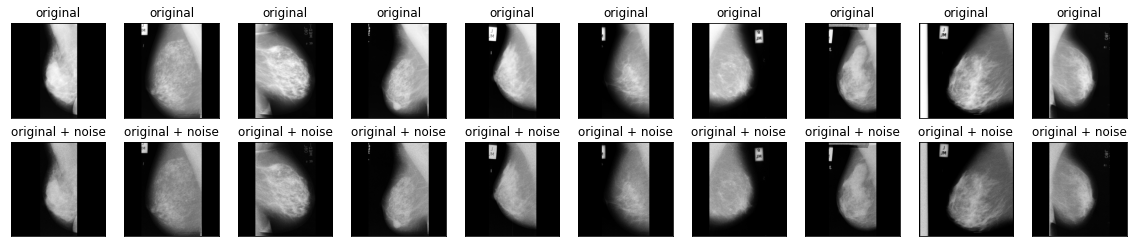

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(y_train[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_train[i])
  plt.title("original + noise")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
